<center><font face='Georgia'>

# Big Data Mining.

    
<center><font size=5 color ='grey' > <i><b>Projet<b></i> : RNN sur le dataset 140Sentiments  </center></font>
                 
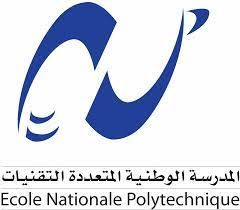


------



> **Fait par :**
<font color ='darkblue' face='Georgia' >   
 1.NOURINE Billel.    
 2.OUCHENE Souhil.  
 3.TOUATI Islem.
</font>
    
> **Avril 2023**
    



In [ ]:
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, count, col
from pyspark.ml.feature import HashingTF, Tokenizer, StopWordsRemover
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql.functions import regexp_replace
from pyspark.ml.feature import RegexTokenizer
from pyspark.sql.functions import udf
from pyspark.sql.functions import array, struct
from pyspark.ml.feature import Word2Vec
from pyspark.sql.functions import split
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType

import os
import sys

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
import keras
from nltk.stem.porter import PorterStemmer
import re
import string



[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Crée une session Spark avec le nom 'Projet_BDM' :
MAX_MEMORY = "5g"
nbr_Cores = 10
spark = SparkSession \
.builder \
.appName("Projet_BDM") \
.config("spark.executor.memory", MAX_MEMORY) \
.config("spark.driver.memory", MAX_MEMORY) \
.config("spark.executor.cores", nbr_Cores) \
.getOrCreate()

spark

In [ ]:
df_pyspark = spark.read.csv("/content/drive/MyDrive/training.1600000.processed.noemoticon.csv", inferSchema=True ,sep=",")

In [ ]:
col_names = ['target', 'id', 'date', 'flag', 'user', 'text']
df_pyspark= df_pyspark.toDF(*col_names)

In [ ]:
df_pyspark.show(truncate=False)

+------+----------+----------------------------+--------+---------------+---------------------------------------------------------------------------------------------------------------------+
|target|id        |date                        |flag    |user           |text                                                                                                                 |
+------+----------+----------------------------+--------+---------------+---------------------------------------------------------------------------------------------------------------------+
|0     |1467810369|Mon Apr 06 22:19:45 PDT 2009|NO_QUERY|_TheSpecialOne_|@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D  |
|0     |1467810672|Mon Apr 06 22:19:49 PDT 2009|NO_QUERY|scotthamilton  |is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!      |
|0     |1467810917|Mon Apr 06 22:19:53 P

In [ ]:
print("Dimensions : {} lignes x {} colonnes".format(df_pyspark.count(), len(df_pyspark.columns)))

Dimensions : 1600000 lignes x 6 colonnes


In [ ]:
# afficher le schéma du Data
df_pyspark.printSchema()

root
 |-- target: integer (nullable = true)
 |-- id: long (nullable = true)
 |-- date: string (nullable = true)
 |-- flag: string (nullable = true)
 |-- user: string (nullable = true)
 |-- text: string (nullable = true)



In [ ]:
# Sélectionner les deux colonnes 'target' et 'text'
data = df_pyspark.select(["target","text"])

In [ ]:
data.show(truncate=False)

+------+---------------------------------------------------------------------------------------------------------------------+
|target|text                                                                                                                 |
+------+---------------------------------------------------------------------------------------------------------------------+
|0     |@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D  |
|0     |is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!      |
|0     |@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds                            |
|0     |my whole body feels itchy and like its on fire                                                                       |
|0     |@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over

In [ ]:
# Les valeurs uniques de la variable "target"
unique_vals = data.select(col('target')).distinct().rdd.flatMap(lambda x: x).collect()
unique_vals

[4, 0]

In [ ]:
# Remplacer toutes les occurrences de 4 dans la colonne 'target' par 1
data = data.withColumn('target', when(col('target') == 4, 1).otherwise(col('target')))

# Compter le nombre d'occurrences de chaque valeur unique dans la colonne "target"
data.groupBy("target").count().show()

+------+------+
|target| count|
+------+------+
|     1|800000|
|     0|800000|
+------+------+



In [ ]:
data.filter(col("target").isNull() | col("text").isNull()).show()

+------+----+
|target|text|
+------+----+
+------+----+



# Data Cleaning :

In [ ]:
data.show(truncate=False)

+------+---------------------------------------------------------------------------------------------------------------------+
|target|text                                                                                                                 |
+------+---------------------------------------------------------------------------------------------------------------------+
|0     |@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D  |
|0     |is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!      |
|0     |@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds                            |
|0     |my whole body feels itchy and like its on fire                                                                       |
|0     |@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over

In [ ]:
# Définir l'expression régulière pour enlever les mentions, les liens et les caractères non alphabétiques
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z]+"

# @\S+  : correspond à tout texte qui commence par un '@' suivi d'un ou plusieurs caractères qui ne sont pas un espace blanc.
# https?:\S+ :  correspond à tout texte qui commence par 'http' ou 'https', suivi d'un ':' et d'un ou plusieurs caractères qui ne sont pas un espace blanc.
# [^A-Za-z]+ : correspond à tout caractère qui n'est pas une lettre majuscule ou minuscule

# Définir une fonction UDF pour nettoyer le texte
def text_cleaning(text):
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    return text

In [ ]:
# Création d'une fonction UDF  à partir de la fonction 'text_cleaning' définie précédemment.
# La fonction UDF permet de l'appliquer sur chaque ligne d'un DataFrame Spark.
text_cleaning_udf = udf(text_cleaning, StringType())

# Appliquer la fonction UDF 'text_cleaning_udf' sur la colonne "text" du DataFrame 'data' et stocker le résultat dans une nouvelle colonne nommée "clean_text".
data = data.withColumn("clean_text", text_cleaning_udf("text"))

In [ ]:
data.show(truncate=False)

+------+---------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------+
|target|text                                                                                                                 |clean_text                                                                                               |
+------+---------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------+
|0     |@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D  |awww that s a bummer you shoulda got david carr of third day to do it d                                  |
|0     |is upset that he can't update his Facebook by texting it... 

In [ ]:
data= data.drop("text")

In [ ]:
# changer le nom de la colonne "clean_text" au "texte"
data = data.withColumnRenamed("clean_text", "text")

In [ ]:
data.show(truncate=False)

+------+---------------------------------------------------------------------------------------------------------+
|target|text                                                                                                     |
+------+---------------------------------------------------------------------------------------------------------+
|0     |awww that s a bummer you shoulda got david carr of third day to do it d                                  |
|0     |is upset that he can t update his facebook by texting it and might cry as a result school today also blah|
|0     |i dived many times for the ball managed to save 50 the rest go out of bounds                             |
|0     |my whole body feels itchy and like its on fire                                                           |
|0     |no it s not behaving at all i m mad why am i here because i can t see you all over there                 |
|0     |not the whole crew                                                      

# Remove letters

In [ ]:
# enlever  les mots de texte ayant une longueur inférieure à deux caractères .

def join_words(text):
    return ' '.join([w for w in text.split() if len(w) > 2])

join_words_udf = udf(join_words, StringType())

data = data.withColumn("text_len", join_words_udf("text"))

data= data.drop("text")

data = data.withColumnRenamed("text_len", "text")

In [ ]:
data.show(truncate=False)

+------+--------------------------------------------------------------------------------------+
|target|text                                                                                  |
+------+--------------------------------------------------------------------------------------+
|0     |awww that bummer you shoulda got david carr third day                                 |
|0     |upset that can update his facebook texting and might cry result school today also blah|
|0     |dived many times for the ball managed save the rest out bounds                        |
|0     |whole body feels itchy and like its fire                                              |
|0     |not behaving all mad why here because can see you all over there                      |
|0     |not the whole crew                                                                    |
|0     |need hug                                                                              |
|0     |hey long time see yes rains bit 

# Tokenazation

In [ ]:
# Définir le tokenizer avec les paramètres appropriés
tokenizer = RegexTokenizer(inputCol="text", outputCol="words", pattern="\W")

# Appliquer le tokenizer au dataframe en utilisant transform :
data = tokenizer.transform(data)


In [ ]:
data.show(truncate=False)

+------+--------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------+
|target|text                                                                                  |words                                                                                                 |
+------+--------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------+
|0     |awww that bummer you shoulda got david carr third day                                 |[awww, that, bummer, you, shoulda, got, david, carr, third, day]                                      |
|0     |upset that can update his facebook texting and might cry result school today also blah|[upset, that, can, update, his, facebook, texting, and, might, cry, result, school, today, also, blah]|
|0   

In [ ]:
data= data.drop("text")
data = data.withColumnRenamed("words", "text")

In [ ]:
data.show(truncate=False)

+------+------------------------------------------------------------------------------------------------------+
|target|text                                                                                                  |
+------+------------------------------------------------------------------------------------------------------+
|0     |[awww, that, bummer, you, shoulda, got, david, carr, third, day]                                      |
|0     |[upset, that, can, update, his, facebook, texting, and, might, cry, result, school, today, also, blah]|
|0     |[dived, many, times, for, the, ball, managed, save, the, rest, out, bounds]                           |
|0     |[whole, body, feels, itchy, and, like, its, fire]                                                     |
|0     |[not, behaving, all, mad, why, here, because, can, see, you, all, over, there]                        |
|0     |[not, the, whole, crew]                                                                         

# Remove Stopwords

In [ ]:
# Créer un objet StopWordsRemover
remover = StopWordsRemover(inputCol="text", outputCol="text_without_stopwords")

# Appliquer la transformation
data = remover.transform(data).select("*")

In [ ]:
data= data.drop("text")
data = data.withColumnRenamed("text_without_stopwords", "text")

In [ ]:
data.show(truncate=False)

+------+---------------------------------------------------------------------------------+
|target|text                                                                             |
+------+---------------------------------------------------------------------------------+
|0     |[awww, bummer, shoulda, got, david, carr, third, day]                            |
|0     |[upset, update, facebook, texting, might, cry, result, school, today, also, blah]|
|0     |[dived, many, times, ball, managed, save, rest, bounds]                          |
|0     |[whole, body, feels, itchy, like, fire]                                          |
|0     |[behaving, mad, see]                                                             |
|0     |[whole, crew]                                                                    |
|0     |[need, hug]                                                                      |
|0     |[hey, long, time, see, yes, rains, bit, bit, lol, fine, thanks]                  |

# Lemmatization

In [ ]:
# Définir le lemmatizer
lemmatizer = WordNetLemmatizer()

# Fonction de lemmatisation pour traiter une liste de phrases
def lemmatize(phrases):
    # Initialiser une liste pour stocker les phrases lemmatisées
    lemmatized_phrases = []

    # Parcourir chaque phrase dans la liste
    for phrase in phrases:
        # Séparer la phrase en mots individuels
        words = phrase.split()
        # Initialiser une liste pour stocker les mots lemmatisés
        lemmatized_words = []
        # Parcourir chaque mot dans la phrase
        for word in words:

            # Appliquer la lemmatisation sur chaque mot
            lemma = lemmatizer.lemmatize(word.lower())
            # Ajouter le mot lemmatisé à la liste
            lemmatized_words.append(lemma)

        # Joindre les mots lemmatisés pour former la phrase lemmatisée
        lemmatized_phrase = ' '.join(lemmatized_words)
        # Ajouter la phrase lemmatisée à la liste
        lemmatized_phrases.append(lemmatized_phrase)

    return lemmatized_phrases


# Définir la fonction UDF
lemmatize_udf = udf(lemmatize, ArrayType(StringType()))

# Appliquer la fonction UDF sur la colonne de texte
data = data.withColumn("lemmatized_text", lemmatize_udf("text"))

In [ ]:
data = data.drop("text")
data = data.withColumnRenamed("lemmatized_text", "text")

In [ ]:
data.show(truncate=False)

+------+---------------------------------------------------------------------------------+
|target|text                                                                             |
+------+---------------------------------------------------------------------------------+
|0     |[awww, bummer, shoulda, got, david, carr, third, day]                            |
|0     |[upset, update, facebook, texting, might, cry, result, school, today, also, blah]|
|0     |[dived, many, time, ball, managed, save, rest, bound]                            |
|0     |[whole, body, feel, itchy, like, fire]                                           |
|0     |[behaving, mad, see]                                                             |
|0     |[whole, crew]                                                                    |
|0     |[need, hug]                                                                      |
|0     |[hey, long, time, see, yes, rain, bit, bit, lol, fine, thanks]                   |

**Concaténer une liste de chaînes de caractères en une seule chaîne**

In [ ]:
# Définir une fonction pour joindre une liste de chaînes de caractères en une seule chaîne de caractères
def join_strings(lst):
    return " ".join(lst)


#Créer une UDF à partir de la fonction
join_strings_udf = udf(join_strings, StringType())

# Appliquez l'UDF à la colonne text.
data = data.withColumn("text_character", join_strings_udf("text"))

In [ ]:
data = data.drop("text")

In [ ]:
data = data.withColumnRenamed("text_character", "text")

In [ ]:
data.show(truncate=False)

+------+---------------------------------------------------------------------+
|target|text                                                                 |
+------+---------------------------------------------------------------------+
|0     |awww bummer shoulda got david carr third day                         |
|0     |upset update facebook texting might cry result school today also blah|
|0     |dived many time ball managed save rest bound                         |
|0     |whole body feel itchy like fire                                      |
|0     |behaving mad see                                                     |
|0     |whole crew                                                           |
|0     |need hug                                                             |
|0     |hey long time see yes rain bit bit lol fine thanks                   |
|0     |nope didn                                                            |
|0     |que muera                                   

# Prendre 150000 instance de chaque classe

In [ ]:
data_0 = data.filter(col("target")==0).orderBy(rand()).limit(150000)

In [ ]:
data_1 = data.filter(col("target") == 1).orderBy(rand()).limit(150000)

In [ ]:
data = data_0.union(data_1)

In [ ]:
data.groupBy("target").count().show()

+------+------+
|target| count|
+------+------+
|     0|150000|
|     1|150000|
+------+------+



In [ ]:
data.count()

300000

In [ ]:
data.columns

['target', 'text']

# Vectorization

In [ ]:
target = data.select(col('target'))
X = data.select(col('text'))

In [ ]:
# divise la colonne text en une liste de mots séparés
X = X.withColumn("text", split(col("text"), " "))

word2vec = Word2Vec(vectorSize=50,# chaque mot sera représenté par un vecteur de dimensions = 50
                    minCount=4 ,# seuls les mots qui apparaissent au moins 4 fois  seront considérés.
                    inputCol="text", outputCol="embedding")
# Ajuster le modèle :
model = word2vec.fit(X)

# Appliquer la transformation
embeddings = model.transform(X)

X = embeddings.drop("text")

X.show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## conversion  du DataFrame PySpark en un tableau NumPy

In [ ]:
# Convertir le DataFrame en une liste d'objets Row
rows = X.select(struct("embedding")).collect()

# Convertir chaque Row á NumPy array
arrays = [np.array(row) for row in rows]

# Empiler les tableaux NumPy verticalement en une seule matrice 2D.
numpy_array = np.vstack(arrays)


In [ ]:
inputs = numpy_array.astype('float32')


In [ ]:
# Convertir la colonne "target" en une liste d'objets

rows_target = target.select(struct("target")).collect()

# Convertir chaque rows_target á NumPy array
arrays_taregt = [np.array(row) for row in rows_target]

# Empiler les tableaux NumPy verticalement en une seule matrice 2D.
numpy_array_target = np.vstack(arrays_taregt)

In [ ]:
target = numpy_array_target.astype('float32')

In [ ]:
target.shape

(300000, 1)

In [ ]:
inputs.shape

(300000, 1, 50)

# Split the data to trainset & testset :

In [ ]:
from sklearn.model_selection import train_test_split

x_train , x_test, y_train, y_test = train_test_split(inputs, target, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
unique, counts = np.unique(y_train, return_counts=True)

In [ ]:
for i in range(len(unique)):
    print(f"{unique[i]} : {counts[i]}")

0.0 : 120093
1.0 : 119907


In [ ]:
unique, counts = np.unique(y_test, return_counts=True)

In [ ]:
for i in range(len(unique)):
    print(f"{unique[i]} : {counts[i]}")

0.0 : 29907
1.0 : 30093


# Create RNN model

In [ ]:
model = Sequential()
# couche RNN
model.add(SimpleRNN(units=32 , # 32 neurons
                    activation='relu', # (Rectified  Linear  Unit) fonction d'activation
                    input_shape=(1, 50) # une séquence d'entrée de 50 embedings pour chaque observation
                    ))
# couche de sortie binaire
model.add(Dense(units=1 # une couche dense qui contient un seul neurone
                , activation='sigmoid' # fonction d'activation
                ))


In [ ]:
# Compilation du model
model.compile(optimizer='adam', #  l'optimiseur utilisé est Adam qui est utiliser pour ajuster les poids du modèle lors de l'apprentissage
              loss='binary_crossentropy', # fonction de perte utiliser pour mesurer l'erreur entre les prédictions du modèle et les valeurs de sortie réelles
              metrics=['accuracy'] # pour évaluer les performances du modèle pendant l'apprentissage
              )

In [ ]:
# Entrainement du model
model.fit(x_train, y_train, epochs=5 ,# Nombre d'itérations
           batch_size=64
          )

Epoch 1/5
3750/3750 [==============================] - 16s 4ms/step - loss: 0.5829 - accuracy: 0.6849
Epoch 2/5
3750/3750 [==============================] - 14s 4ms/step - loss: 0.5626 - accuracy: 0.7035
Epoch 3/5
3750/3750 [==============================] - 14s 4ms/step - loss: 0.5556 - accuracy: 0.7099
Epoch 4/5
3750/3750 [==============================] - 13s 4ms/step - loss: 0.5517 - accuracy: 0.7136
Epoch 5/5
3750/3750 [==============================] - 13s 4ms/step - loss: 0.5490 - accuracy: 0.7156


In [ ]:
# Evaluation du modele sur les données test
loss, accuracy = model.evaluate(x_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

1875/1875 [==============================] - 6s 3ms/step - loss: 0.5517 - accuracy: 0.7142
Test Loss: 0.5516737103462219
Test Accuracy: 0.7141666412353516


# Confusion matrix

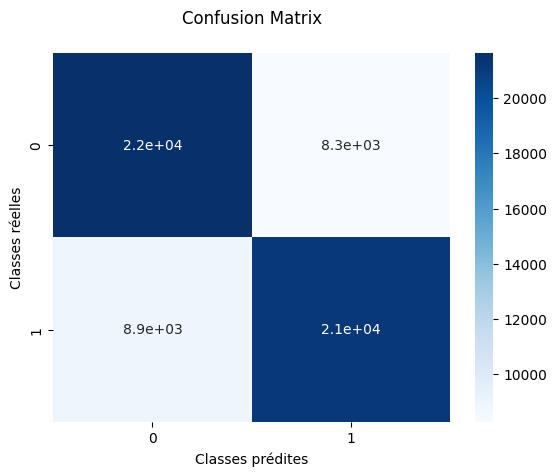

In [ ]:
ax = sns.heatmap(confusion_matrix(y_test, ypred), annot=True, cmap="Blues")
ax.set_title('Confusion Matrix\n');
ax.set_xlabel('Classes prédites')
ax.set_ylabel('Classes réelles');

ax.xaxis.set_ticklabels(['0', '1'])
ax.yaxis.set_ticklabels(['0', '1'])

plt.show()